# # Análisis de redes con python

**Universidad Nacional de Colombia**  
**Elaborado por:** Juan Jose Ardila Ortega


## 
Las redes o los grafos son otro metodo para modelaar y analizar las relaciones entre entidades. Y para comprenderlo mejor, estos constan de nodos o vertices y aristas o enlaces, 
que permiten relacionar claves con valores.

### ¿Por qué modelar con grafos?

Esto permite llegar a repsonder preguntas como:

*¿Quiénes son las personas influyentes clave dentro de una comunidad en línea?*
*¿Cuál es la ruta óptima entre dos ciudades en una red de transporte?*
*¿Existen clusters o comunidades densamente conectadas en la red?*

Sin embargo, en SIG el problema compun es buscar la ruta más corta  en redes, por lo que es muy frecuente encontara estos modleo en sistemas de navegación y de transporte donde el analisis es de multiples puntos. Asimismo, es posible detcetar estructuras, calcular metricas, identificar puentes criticos o detectar agrupaiones.

Para comprender de mejor manera como se comporta un grafo, la libreria **Networkx** permite visualizar nodos y aristas y su relación.

[1, 2, 3]
[(1, 2)]


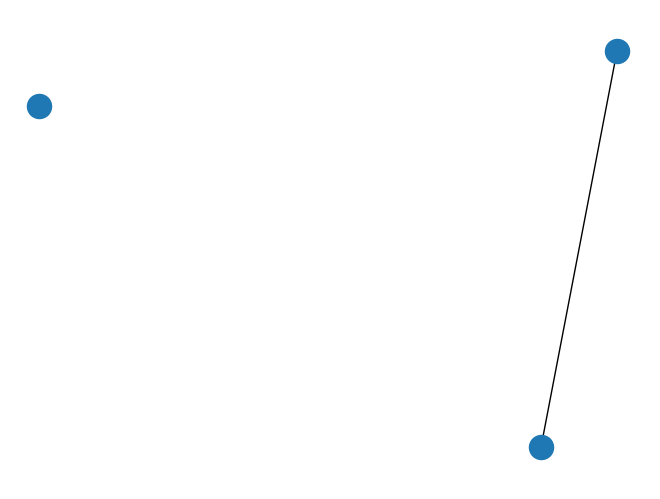

In [1]:
import networkx as nx

# Grafo vacio
G = nx.Graph()

# Añadir nodos y aristas
G.add_nodes_from([1, 2, 3])
G.add_edge(1, 2)

# Inspeccionar nodos y aristas
print(G.nodes())    # → [1, 2, 3]
print(G.edges())    # → [(1, 2)]

# Adjuntar metadatos
G.nodes[1]["label"] = "blue"

# Visualización básica
nx.draw(G)


Para este ejercicio se trabajara con la libreria NetworkX, la cual permite analizar redes mediante distintos algortimos de encaminamiento, como el de Dijkstra o el A*, que buscan los cmainos más cortos en las redes de transporte. Adicionalmente, el paquete OSMnx, permite trabajar con las redes de OpenStreetMap y así mismo, tiene distintas funcionalidades sobre los mismos, lo que permitira hallar la ruta más corta entre dos puntos sobre una red de trasnporte urbana.


## Obtención de la red

Gracias a OSM, es poisble extraer información de cualquier parte del mundo que cuente con información, por lo que para este caso se trabjará con datos de la Localidad de Suba en Bogotá.

In [28]:
!pip install osmnx==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.0 MB/s eta 0:00:0000:01
  Attempting uninstall: osmnx
    Found existing installation: osmnx 2.0.4
    Uninstalling osmnx-2.0.4:
      Successfully uninstalled osmnx-2.0.4


In [2]:
import osmnx

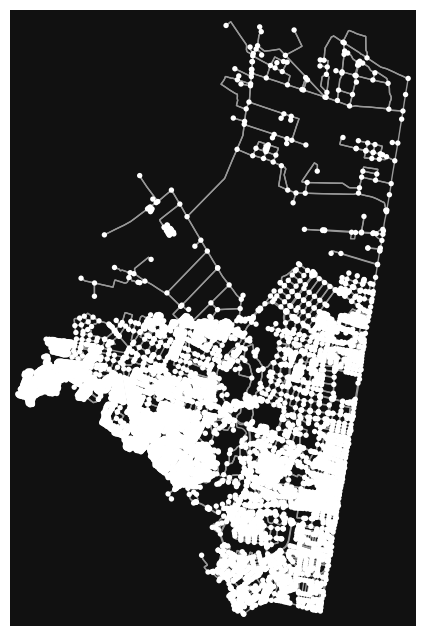

In [6]:
PLACE_NAME = "Suba, Bogotá, Colombia"
graph = osmnx.graph_from_place(
    PLACE_NAME,
    network_type="drive"
)
figure, ax = osmnx.plot_graph(graph)


In [ ]:
Para poder hacer uso del OMSnx, es necesario preparar los datos visualizados:

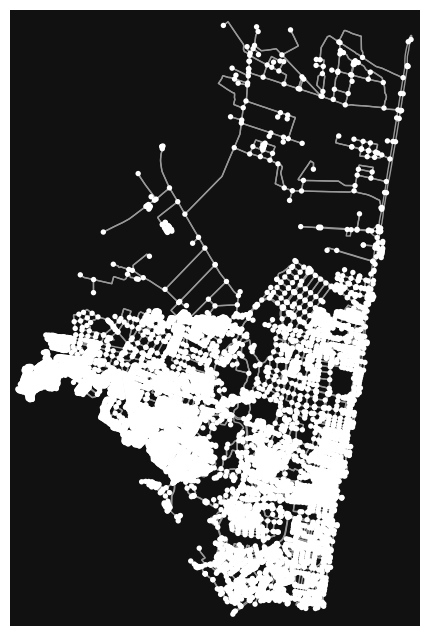

In [7]:
# Obtener el polígono del área de interés
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Reproyectar el polígono a un CRS local proyectado (Magna Sirgas Bogotá)
place_polygon = place_polygon.to_crs("EPSG:3116")

# Buffer por 200 metros
place_polygon["geometry"] = place_polygon.buffer(200)

# Reproyectar el polígono de nuevo a WGS84
place_polygon = place_polygon.to_crs("EPSG:4326")

# Recupera el gráfico de la red
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="drive"
)

fig, ax = osmnx.plot_graph(graph)

### Visión de los datos

Para este caso, sesta red que represneta las rutas de transito para vehiculos, se puede analizar que valores se le asigna a los nodos y las aristas, 
por lo que se transforma la red en un marco de datos geográfico, que se visualiza como tabla y muestra las relaciones atribuibles entre los nodos y las aristas encontradas.


In [8]:
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid     highway lanes maxspeed  \
u         v          key                                                       
259665451 5718775594 0                  809284675       trunk     3       50   
          273536445  0                 1153629523       trunk     2       60   
259705339 259705340  0    [1326283107, 913056613]       trunk     3      NaN   
259705340 273536194  0                   25123212  trunk_link     1      NaN   
          4096482172 0                  913056617       trunk     2      NaN   

                                        name  oneway reversed      length  \
u         v          key                                                    
259665451 5718775594 0    Avenida Carrera 45    True    False  745.334231   
          273536445  0    Avenida Carrera 45    True    False  110.133567   
259705339 259705340  0    Avenida Carrera 45    True    False  122.389094   
259705340 273536194  0                   NaN    True    False  253.568306   
          4096482172 0    Avenida Carrera 45    True    False   68.598364   

                                                                   geometry  \
u         v          key                                                      
259665451 5718775594 0    LINESTRING (-74.04663 4.75285, -74.04657 4.752...   
          273536445  0    LINESTRING (-74.04663 4.75285, -74.04663 4.752...   
259705339 259705340  0    LINESTRING (-74.04657 4.75075, -74.04654 4.750...   
259705340 273536194  0    LINESTRING (-74.04636 4.75183, -74.04628 4.752...   
          4096482172 0    LINESTRING (-74.04636 4.75183, -74.04629 4.752...   

                          ref bridge access junction width  
u         v          key                                    
259665451 5718775594 0    NaN    NaN    NaN      NaN   NaN  
          273536445  0    NaN    NaN    NaN      NaN   NaN  
259705339 259705340  0    NaN    NaN    NaN      NaN   NaN  
259705340 273536194  0    NaN    NaN    NaN      NaN   NaN  
          4096482172 0    NaN    NaN    NaN      NaN   NaN

Es posible mirar de que tipo de calles se compone la red.

In [9]:
edges["highway"].value_counts()

highway
residential                    14087
tertiary                        2219
secondary                        894
primary                          607
trunk                            364
trunk_link                       114
primary_link                      79
unclassified                      54
tertiary_link                     13
secondary_link                    12
[residential, unclassified]        4
[primary_link, primary]            2
[tertiary, residential]            1
[residential, tertiary]            1
[trunk, primary]                   1
Name: count, dtype: int64

### Transformación a sistema de referencia proyectado

El sistema de referencia base es el WGS84, sin embargo, es geográfico. Sin embargo, los valores obtenidos son en valores en grados, 
pero los valores para analizar debería ser en metros.

Por lo que se torna de gran importancia transformar los goedatos de entrada, si este valor del sistema de proyección no se pone,
automaticamente se pondra un UTM más apropiado.

In [10]:
# Transformar el gráfico a UTM
graph = osmnx.project_graph(graph) 

# Extraer nodos y aristas reproyectados
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Análisis de las propiedades de la red

Luego de preparar el grafo, es posible calcular las estadísticas y características básicas del mismo:


In [11]:
# Calcular las estadísticas de la red
osmnx.basic_stats(graph)

{'n': 7681,
 'm': 18452,
 'k_avg': 4.8045827366228355,
 'edge_length_total': 1575632.9676006532,
 'edge_length_avg': 85.3909043789645,
 'streets_per_node_avg': 2.8220283817211302,
 'streets_per_node_counts': {0: 0, 1: 1346, 2: 21, 3: 4981, 4: 1320, 5: 13},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.17523759927092827,
  2: 0.002734019007941674,
  3: 0.648483270407499,
  4: 0.1718526233563338,
  5: 0.0016924879572972268},
 'intersection_count': 6335,
 'street_length_total': 949307.7042815512,
 'street_segment_count': 10760,
 'street_length_avg': 88.2256230744936,
 'circuity_avg': 1.0427189872501874,
 'self_loop_proportion': 0.0009293680297397769}

Para obtener estadísticas mas robustas, es posible generar un polígono envolvente y así analizar el área que afecta esta red.


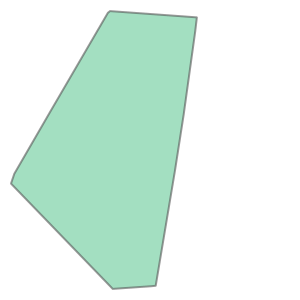

In [12]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [13]:
stats = osmnx.basic_stats(graph, area=convex_hull.area)
stats

{'n': 7681,
 'm': 18452,
 'k_avg': 4.8045827366228355,
 'edge_length_total': 1575632.9676006532,
 'edge_length_avg': 85.3909043789645,
 'streets_per_node_avg': 2.8220283817211302,
 'streets_per_node_counts': {0: 0, 1: 1346, 2: 21, 3: 4981, 4: 1320, 5: 13},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.17523759927092827,
  2: 0.002734019007941674,
  3: 0.648483270407499,
  4: 0.1718526233563338,
  5: 0.0016924879572972268},
 'intersection_count': 6335,
 'street_length_total': 949307.7042815512,
 'street_segment_count': 10760,
 'street_length_avg': 88.2256230744936,
 'circuity_avg': 1.0427189872501874,
 'self_loop_proportion': 0.0009293680297397769,
 'node_density_km': 69.62557102857201,
 'intersection_density_km': 57.42455311365755,
 'edge_density_km': 14282.560226616191,
 'street_density_km': 8605.141386854026}

In [24]:
Primero se debe realizar una copia de la información, para poder explotar los valores que incluye la lista de la columna **Highway**.

In [14]:
edges_1= edges.copy()

edges_1=edges_1.explode("highway")

edges_1["highway"]= edges_1["highway"].fillna("unknow").astype(str)

In [ ]:
1. **Calcular** el total de las longitudes de las calles resideniales, priamrias y secundarias.

In [15]:
Long_Clase_Km= (
    edges_1.groupby("highway")["length"]
    .sum()
    .sort_values(ascending=False)
    / 1000
)

Long_Clase_Km.loc[["residential", "primary", "secondary"]]


highway
residential    1115.665317
primary          78.169756
secondary        69.396288
Name: length, dtype: float64

In [ ]:
2. **Comparar** la media de las clases.

In [16]:
Media_Clase= (
    edges_1.groupby("highway")["length"]
    .mean()
    .sort_values(ascending=False)
)

display(Media_Clase)


highway
unclassified      582.776610
trunk             188.630625
trunk_link        143.169689
primary           128.147142
tertiary           85.720085
primary_link       82.811493
residential        79.164501
secondary          77.624484
secondary_link     57.679791
tertiary_link      17.501407
Name: length, dtype: float64

In [ ]:
3. **Visualizar** las 5 clases con mayor longitud de calles.

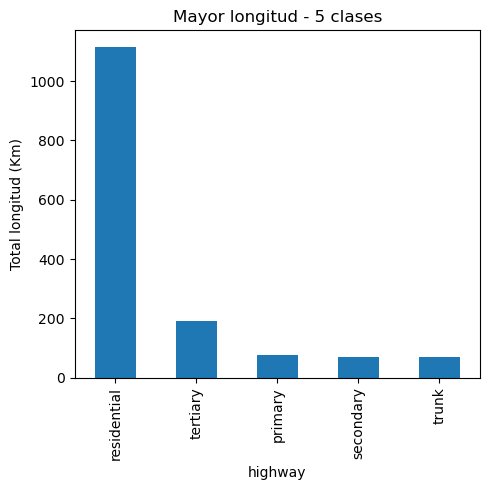

In [17]:
import matplotlib.pyplot as plt

Long_Clase_Km.head(5).plot(kind="bar", figsize=(5, 5))
plt.ylabel("Total longitud (Km)")
plt.title("Mayor longitud - 5 clases")
plt.tight_layout()
plt.show()

## Análisis del camino más corto

Para poder realizar este calculo entre dos puntos conocidos se debe preparar lo siguiente:


In [18]:
#Punto de origen
origin = (
    osmnx.geocode_to_gdf("parque la gaitana, bogota")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

#Punto de destino
destination = (
    osmnx.geocode_to_gdf("cerro la conejera, bogota")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

Posteriormente, es posible buscar un nodo ocncido en el grafo, que se aproxime a los valores añadidos con anterioridad.

In [19]:
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

507912169

In [20]:
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

310327256

### Enrutamiento

Ya creado los puntos de origen y destino, es posible, hacer uso del grafo y de los identificadores de los nodos de origen y destino.


In [21]:
# Encontrar el camino más corto entre el origen y el destino
route = osmnx.shortest_path(graph, origin_node_id, destination_node_id)
route

[507912169,
 507912081,
 5113954454,
 507705392,
 5113954459,
 507943335,
 507943334,
 1068231784,
 1068231480,
 1068231555,
 1068559811,
 507943310,
 310613550,
 320196272,
 4064302678,
 310613554,
 507180826,
 6453782953,
 507173627,
 1068231544,
 310613556,
 504421079,
 323327696,
 323327927,
 323328020,
 320196083,
 507144041,
 323328271,
 320196045,
 514597063,
 310613561,
 514611064,
 514602806,
 4064302677,
 871073063,
 262391363,
 310613563,
 871072962,
 514539058,
 871073072,
 262391121,
 262391335,
 871073047,
 871072958,
 1833722136,
 896307122,
 4913349660,
 5378334896,
 5379505621,
 312094081,
 4226160270,
 517610906,
 5379680136,
 4863130265,
 5379680109,
 5930273582,
 4198906778,
 316735957,
 4136288075,
 4112524442,
 5379785795,
 5379785797,
 517647649,
 317503619,
 5379785956,
 308903869,
 5379785763,
 998072991,
 316736092,
 517738973,
 308903871,
 5163394843,
 8232838620,
 517753307,
 5379785941,
 317503653,
 9849222121,
 1868086124,
 1868086125,
 1868086132,
 540044

El anterior listado, muestra los nodos que conectan estos dos puntos y es posible generar geodataframe, que muestre gráficamente la línea.

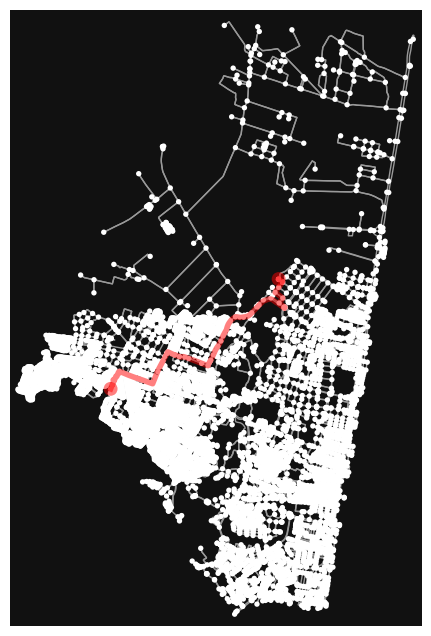

In [22]:
# Trazar el camino más corto
fig, ax = osmnx.plot_graph_route(graph, route)



1. **Calculate** a second route that avoids `motorway` and `trunk` streets.  
2. **Compare** its length with the original shortest route.  
3. **Discuss** in one sentence why constrained routes can be useful for certain users.

> 💡 You can filter `edges` before building a sub-graph or use `osmnx.utils_graph.get_route_edge_attributes`.


In [ ]:
**Calcular** una segunda ruta que evite las calles "Cicleway" y "Trunk".

In [23]:
edges_to_keep = [
    (u, v, k) for u, v, k, d in graph.edges(keys=True, data=True)
    if not (
        d.get("highway") == "trunk" or
        d.get("highway") == "cycleway" or
        (isinstance(d.get("highway"), list) and (
            "trunk" in d["highway"] or "cycleway" in d["highway"])
        )
    )
]

In [24]:
graph_filtered = graph.edge_subgraph(edges_to_keep).copy()

In [25]:
import networkx as nx

route_alt = nx.shortest_path(graph_filtered, origin_node_id, destination_node_id, weight="length")

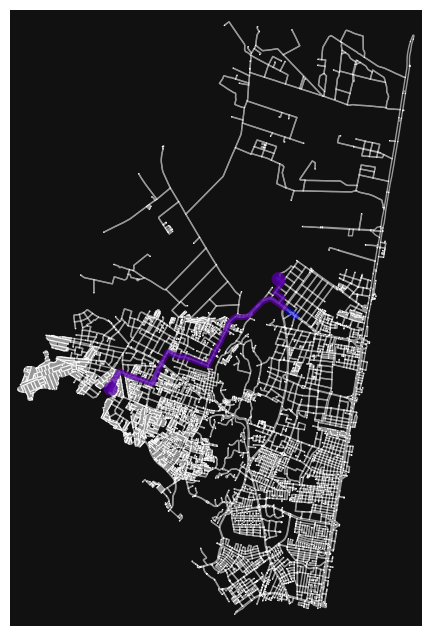

In [26]:
fig, ax = osmnx.plot_graph_routes(
    graph,
    routes=[route, route_alt],
    route_colors=["red", "blue"],
    route_linewidth=3,
    node_size=1
)

In [ ]:
**Comparar** su longitud con la ruta más corta original.

In [29]:
from osmnx.utils_graph import get_route_edge_attributes

# Longitud de la ruta original
length_original = sum(get_route_edge_attributes(graph, route, "length"))

# Longitud de la ruta alternativa
length_alt = sum(get_route_edge_attributes(graph, route_alt, "length"))

# Imprimir comparación
print(f"Longitud de la ruta original: {length_original:.2f} m")
print(f"Longitud de la ruta alternativa: {length_alt:.2f} m")
print(f"Diferencia: {length_alt - length_original:.2f} m")


Longitud de la ruta original: 8105.22 m
Longitud de la ruta alternativa: 8865.20 m
Diferencia: 759.98 m


In [ ]:
**Discutir** en una frase por qué las rutas restringidas pueden ser útiles para determinados usuarios.

In [ ]:
Debido a que los tipos distintos de vía pueden ser usados por tamaños distintos de vehiculos y algunas zonas no son capaces de contar con la vpias aptas.

In [30]:
from osmnx.utils_graph import get_route_edge_attributes

tipos = get_route_edge_attributes(graph, route_alt, "highway")
print(tipos)


['residential', 'residential', 'secondary', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'residential', 'tertiary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'primary', 'primary', 'primary', 'primary', 'primary', 'primary', 'primary', 'primary', 'tertiary', 'tertiary', 'tertiary', 'residential', 'residential', 'residential', 'residential', 'residential', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', 'secondary', '

## Guardar la ruta

Para poder reutilizar los resultados, es posible almacenarlos en un geodataframe en python especificamente en un archivo Geopackage.

In [32]:
# Obtener los nodos a lo largo del camino más corto
route_nodes = nodes.loc[route]
route_nodes

,y,x,street_count,highway,geometry
osmid,,,,,
507912169,524029.721514,598840.849330,3,NaN,POINT (598840.849 524029.722)
507912081,524136.112815,598890.034318,3,NaN,POINT (598890.034 524136.113)
5113954454,524247.051679,598933.623426,3,NaN,POINT (598933.623 524247.052)
507705392,524272.670857,598911.341888,4,NaN,POINT (598911.342 524272.671)
5113954459,524282.346043,598921.455521,3,NaN,POINT (598921.456 524282.346)
...,...,...,...,...,...
312417718,526675.140887,603347.535823,3,NaN,POINT (603347.536 526675.141)
917879228,526810.612928,603446.470931,3,NaN,POINT (603446.471 526810.613)
1896247302,526947.173015,603548.675963,4,NaN,POINT (603548.676 526947.173)


Ahora se genera linestring a partir de los puntos de los nodos:

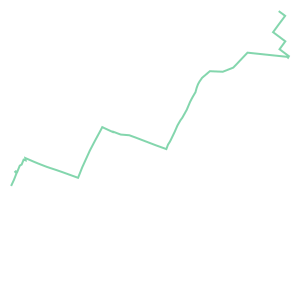

In [33]:
import shapely.geometry

# Crear una geometría para el camino más corto
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

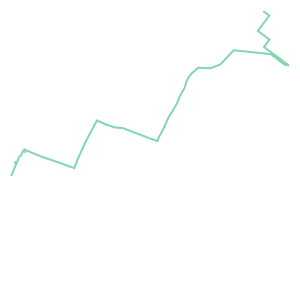

In [35]:
route_alt_nodes = nodes.loc[route_alt]

route_alt_line = shapely.geometry.LineString(
    list(route_alt_nodes.geometry.values)
)
route_alt_line

Y en este paso es posible crear el geodataframe que contenga los nodos de la ruta.

In [34]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (598840.849 524029.722, 598890.034 ...","[507912169, 507912081, 5113954454, 507705392, ...",7927.019597


Es posible validar que la información este quedando bien, incluyendo las construcciones que se vinculan a la red y los nodos de origen y destino.

In [36]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

Finalmente es posible visualizar todos los elmentos de la red:

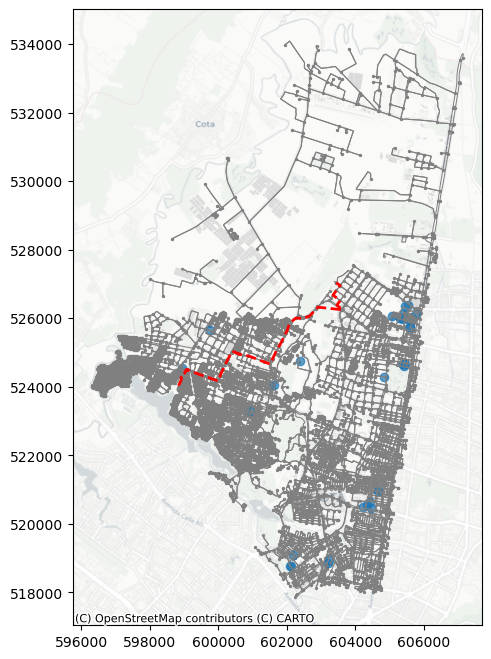

In [38]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

## Preparar los datos para guardarlos en un fichero

Los datos contienen elementos de tipo lista, que deben ser convertidos en cadenas antes del almacenamiento.

In [39]:
edges.head()

osmid highway   lanes maxspeed  \
u          v          key                                                      
259665451  5718775594 0                   809284675   trunk       3       50   
           273536445  0                  1153629523   trunk       2       60   
5718775594 5718775821 0     [1326265792, 910677112]   trunk  [4, 3]       50   
273536445  4618501555 0    [1326273115, 1153629523]   trunk       2       60   
259705339  259705340  0     [1326283107, 913056613]   trunk       3      NaN   

                                         name  oneway reversed      length  \
u          v          key                                                    
259665451  5718775594 0    Avenida Carrera 45    True    False  745.334231   
           273536445  0    Avenida Carrera 45    True    False  110.133567   
5718775594 5718775821 0    Avenida Carrera 45    True    False  262.272461   
273536445  4618501555 0    Avenida Carrera 45    True    False   84.051228   
259705339  259705340  0    Avenida Carrera 45    True    False  122.389094   

                                                                    geometry  \
u          v          key                                                      
259665451  5718775594 0    LINESTRING (605729.205 525417.902, 605735.098 ...   
           273536445  0    LINESTRING (605729.205 525417.902, 605728.732 ...   
5718775594 5718775821 0    LINESTRING (605644.703 524685.04, 605629.63 52...   
273536445  4618501555 0    LINESTRING (605720.394 525309.04, 605711.722 5...   
259705339  259705340  0    LINESTRING (605735.448 525185.86, 605739.373 5...   

                          bridge  ref access junction width  
u          v          key                                    
259665451  5718775594 0      NaN  NaN    NaN      NaN   NaN  
           273536445  0      NaN  NaN    NaN      NaN   NaN  
5718775594 5718775821 0      NaN  NaN    NaN      NaN   NaN  
273536445  4618501555 0      NaN  NaN    NaN      NaN   NaN  
259705339  259705340  0      NaN  NaN    NaN      NaN   NaN

In [41]:
# Columnas con valores no válidos
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "access",   
]

# Convertir las columnas seleccionadas a formato cadena
edges[problematic_columns] = edges[problematic_columns].astype(str)

In [42]:
route_geom["osm_nodes"] = route_geom["osm_nodes"].astype(str)

## Save the data:


In [43]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [ ]:
**Crear** un buffer de 50 m alrededor de la ruta y seleccionar los edificios que la cruzan.

In [44]:
buffer_50m = route_line.buffer(50)

In [ ]:
**Contar** los edificios en total y por etiqueta `building` dentro de este corredor.

In [45]:
buildings_near = buildings[buildings.intersects(buffer_50m)]

In [46]:
buildings_near["building"].value_counts()

building
yes           24
apartments     4
roof           2
Name: count, dtype: int64

In [ ]:
**Exportar** el resultado a `buildings_along_route.geojson`. 

In [47]:
buildings_near.to_file("buildings_near.geojson", driver="GeoJSON")

Ahora, es posible comparar los metodos de Dijkstra y A*, para poder analizar si existe algun cambio respecto a la red generada.

El pirmer paso es definir reglas claras frente a las distancias a usar en el algortimo A*, para esta prueba euclidiana y Manhattan.

In [48]:
def euclidean_heuristic(u, v):
    ux, uy = graph.nodes[u]['x'], graph.nodes[u]['y']
    vx, vy = graph.nodes[v]['x'], graph.nodes[v]['y']
    return ((ux - vx)**2 + (uy - vy)**2)**0.5


In [49]:
def manhattan_heuristic(u, v):
    ux, uy = graph.nodes[u]['x'], graph.nodes[u]['y']
    vx, vy = graph.nodes[v]['x'], graph.nodes[v]['y']
    return abs(ux - vx) + abs(uy - vy)


In [ ]:
Posterioemnte, es poisble reutilizar los nodos de origen y destino, pero ahora, llamando el comando para este algortimo y las heuristicas generadas.

In [50]:
route_astar = nx.astar_path(
    graph,
    origin_node_id,
    destination_node_id,
    heuristic=euclidean_heuristic,
    weight="length"
)


In [51]:
route_astar1 = nx.astar_path(
    graph,
    origin_node_id,
    destination_node_id,
    heuristic=manhattan_heuristic,
    weight="length"
)


In [ ]:
Posterioemnte, es posible visualizar las rutas generadas.

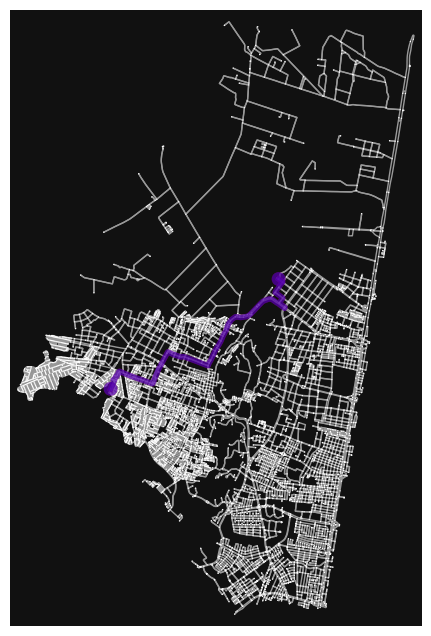

In [52]:
fig, ax = osmnx.plot_graph_routes(
    graph,
    routes=[route_astar, route_astar1],
    route_colors=["red", "blue"],
    route_linewidth=3,
    node_size=1
)

In [ ]:
Para este caso se relaiza la comparación de los resultados entre las pruebas de distancia.

In [53]:
# Longitud de la ruta original
length_A_E = sum(get_route_edge_attributes(graph, route_astar, "length"))

# Longitud de la ruta alternativa
length_A_M = sum(get_route_edge_attributes(graph, route_astar1, "length"))

# Imprimir comparación
print(f"Longitud de la ruta A* Euclidian: {length_A_E:.6f} m")
print(f"Longitud de la ruta A* Manhattan: {length_A_M:.6f} m")
print(f"Diferencia: {length_A_M - length_A_E:.6f} m")

Longitud de la ruta A* Euclidian: 8105.220544 m
Longitud de la ruta A* Manhattan: 8105.220544 m
Diferencia: 0.000000 m


In [ ]:
Asimismo, comparar las rutas de ambos metodos realizados.

In [54]:
# Longitud de la ruta original
length_dijktras = sum(get_route_edge_attributes(graph, route, "length"))

# Longitud de la ruta alternativa
length_A = sum(get_route_edge_attributes(graph, route_astar, "length"))

# Imprimir comparación
print(f"Longitud de la ruta dijktra´s: {length_dijktras:.6f} m")
print(f"Longitud de la ruta A*: {length_A:.6f} m")
print(f"Diferencia: {length_A - length_dijktras:.6f} m")

Longitud de la ruta dijktra´s: 8105.220544 m
Longitud de la ruta A*: 8105.220544 m
Diferencia: 0.000000 m
